In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import warnings
from plotnine import *
warnings.filterwarnings('ignore')
import plotly.express as px
import plotly.graph_objects as go
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams
from itertools import product
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_log_error


In [2]:
rcParams['figure.figsize'] = 12, 6
plt.style.use('Solarize_Light2')

https://www.kaggle.com/datasets/ahmedadam415/digital-currency-time-series

### Data Content:
The data was prepared using Alpha Vantage API
The data represents historical daily time series for a digital currency (BTC) traded on the Saudi market (SAR/Sudi Riyal)
Prices and volumes are quoted in both SAR & USD.
Data date range: 2018-05-11 to 30.01.2021

In [3]:
df_1 = pd.read_csv('gemini_BTCUSD_2020_1min.csv', parse_dates=True)

In [4]:
df_1['Date'] = pd.to_datetime(df_1['Date'])

In [5]:
df_1.head()

,Unix Timestamp,Date,Symbol,Open,High,Low,Close,Volume
0,1.618880e+12,2021-04-20 00:02:00,BTCUSD,55717.47,55723.00,55541.69,55541.69,2.406734
1,1.618880e+12,2021-04-20 00:01:00,BTCUSD,55768.94,55849.82,55711.74,55717.47,0.573458
2,1.618880e+12,2021-04-20 00:00:00,BTCUSD,55691.79,55793.15,55691.79,55768.94,3.309904
3,1.618880e+12,2021-04-19 23:59:00,BTCUSD,55777.86,55777.86,55677.92,55691.79,0.684934
4,1.618880e+12,2021-04-19 23:58:00,BTCUSD,55803.50,55823.88,55773.08,55777.86,0.477225


In [6]:
df = df_1.drop(['Unix Timestamp', 'Symbol', 'Open', 'High', 'Low', 'Volume'], axis=1)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 658065 entries, 0 to 658064
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   Date    658065 non-null  datetime64[ns]
 1   Close   658065 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 10.0 MB


In [8]:
df.head()

,Date,Close
0,2021-04-20 00:02:00,55541.69
1,2021-04-20 00:01:00,55717.47
2,2021-04-20 00:00:00,55768.94
3,2021-04-19 23:59:00,55691.79
4,2021-04-19 23:58:00,55777.86


In [9]:
downsample = df[['Date','Close']].resample('D', on='Date').mean().reset_index(drop=False)

In [10]:
df = downsample.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    476 non-null    datetime64[ns]
 1   Close   476 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 7.6 KB


In [11]:
df = df.set_index('Date')

In [12]:
df.head()

,Close
Date,
2020-01-01,7195.641243
2020-01-02,7072.362910
2020-01-03,7215.680840
2020-01-04,7320.664035
2020-01-05,7429.535437


In [13]:
df.tail()

,Close
Date,
2021-04-16,61763.458840
2021-04-17,61342.304028
2021-04-18,56082.597573
2021-04-19,56410.551278
2021-04-20,55676.033333


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 476 entries, 2020-01-01 to 2021-04-20
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   476 non-null    float64
dtypes: float64(1)
memory usage: 7.4 KB


Text(0.5, 1.0, 'Daily Digital currency price')

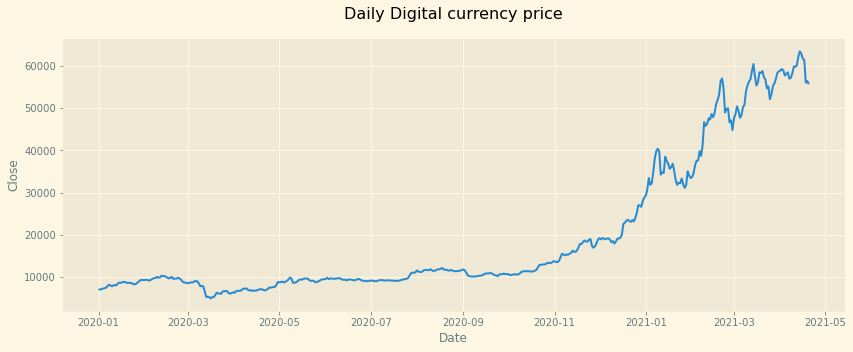

In [63]:
plt.figure(figsize = (14, 5))
sns.lineplot(x=df.index, y=df.Close)
plt.title("Daily Digital currency price", pad=20)

### Before we can build a model, we must check if the time series is stationary. 

Stationarity is a key part of time series analysis. <br>
Stationarity means that the manner in which time series data changes is constant. A stationary time series will not have any trends or seasonal patterns. We should check for stationarity because it not only makes modeling time series easier, but it is an underlying assumption in many time series methods. Specifically, stationarity is assumed for a wide variety of time series forecasting methods including autoregressive moving average (ARMA), ARIMA and Seasonal ARIMA (SARIMA).

https://builtin.com/data-science/time-series-python

#### There are several ways to test stationarity we will use the following two:

#### 1. Rolling Statistic stationarity test:<br>

The time series is stationary if they remain constant with time (with the naked eye look to see if the lines are straight and parallel to the x-axis).

#### 2. Dickey-Fuller test

The time series is considered stationary if the p-value is low (according to the null hypothesis) and the critical values at 1%, 5%, 10% confidence intervals are as close as possible to the ADF Statistics.


In [16]:
#1.  rolling statistic

# this is daily data, lets set window of 3 months

rolling_mean = df.Close.rolling(window = 30).mean()
rolling_std = df.Close.rolling(window = 30).std()

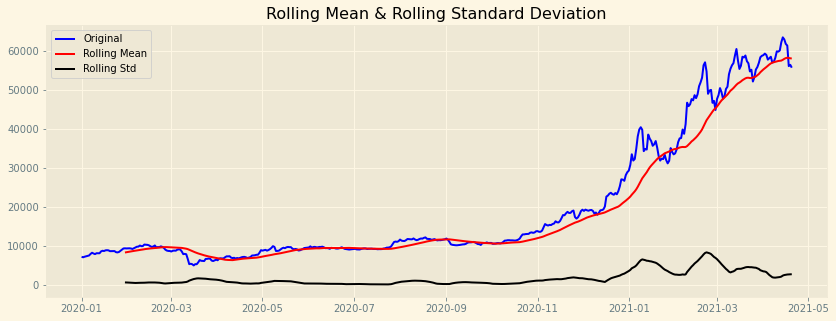

In [17]:
# plotting results

plt.figure(figsize = (14, 5))
plt.plot(df.Close, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

We can see, the rolling mean increases with time. To be able to say that timeseries is stationary both rolling mean and rolling standard deviation should run parrarel to the x-axis. Therefore, we can conclude that the time series is not stationary.

A <b> Dickey-Fuller test </b> is a unit root test that tests the null hypothesis that α=1 in the following model equation. alpha is the coefficient of the first lag on Y.<br>
Null Hypothesis (H0): alpha=1. <br>

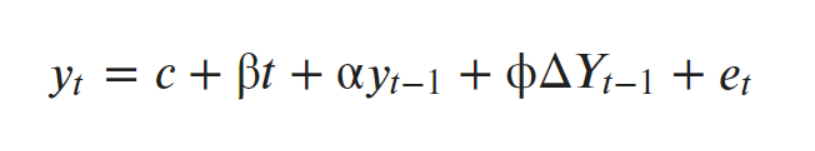

where,

y(t-1) = lag 1 of time series<br>
delta Y(t-1) = first difference of the series at time (t-1)<br>
Fundamentally, it has a similar null hypothesis as the unit root test. That is, the coefficient of Y(t-1) is 1, implying the presence of a unit root. If not rejected, the series is taken to be non-stationary.<br>

The Augmented Dickey-Fuller test evolved based on the above equation and is one of the most common form of Unit Root test.<br>


<b> How does Augmented Dickey Fuller (ADF) Test work? </b>

The ADF test expands the Dickey-Fuller test equation to include high order regressive process in the model. <br>


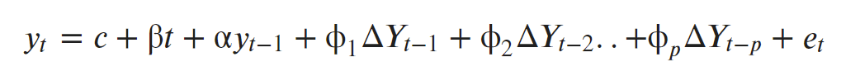

The null hypothesis however is still the same as the Dickey Fuller test.

A key point to remember here is: Since the null hypothesis assumes the presence of unit root, that is α=1, the p-value obtained should be less than the significance level (say 0.05) in order to reject the null hypothesis. Thereby, inferring that the series is stationary.


In [18]:
# Dicky-Fuller test:

result = adfuller(df['Close'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: 1.3950905642959415
p-value: 0.9970917246171098
Critical Values:
	1%: -3.4446148284445153
	5%: -2.8678299626609314
	10%: -2.5701203107928157


<Figure size 1008x360 with 0 Axes>

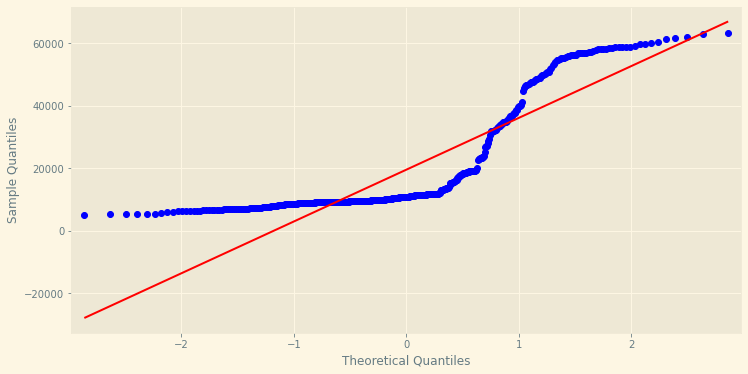

In [19]:
# qqplot for the 'Close' column
plt.figure(figsize = (14, 5))
x = sm.qqplot(df['Close'], line = 's')
plt.show()

#### The ADF Statistic 
is far from the critical values and the p-value is greater than the threshold (0.05). <br>
Thus, we can conclude that the time series is <br> not stationary </b>.

#### There are multiple transformations that we can apply to a time series to render it stationary. <br>
For instance, we subtract the rolling mean, Mathematical Transformation, Seasonal Differencing.

#### We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

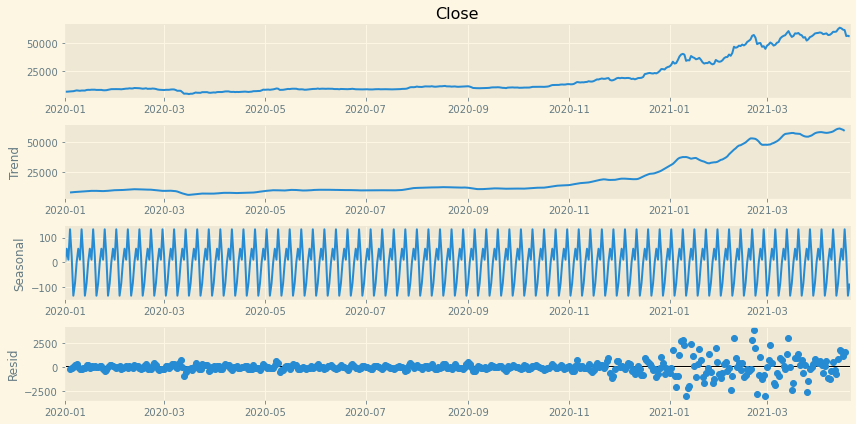

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df.Close, model='additive')
result.plot();

### But we will use ARIMA model for our problem, this model authomatically deals with stationarity.

<b> ARIMA </b> , also known as the Box-Jenkins model, is a generalization of the ARMA model by including integrated components. The integrated components are useful when data has non-stationarity, and the integrated part of ARIMA helps in reducing the non-stationarity. <br>

<b> The ARIMA applies differencing on time series one or more times to remove non-stationarity effect.</b> <br>
The ARIMA(p, d, q) represent the order for AR, MA, and differencing components. The major difference between ARMA and ARIMA models is the d component, which updates the series on which forecasting model is built. The d component aims to de-trend the signal to make it stationary and ARMA model can be applied to the de-trended dataset. 

Practical time series, 
https://learning.oreilly.com/library/view/practical-time-series/9781788290227/37356dee-c5d8-49b3-a4c2-652e9f32a885.xhtml

First we have to decide the order, the values for p,d and q.

### Autocorrelation Function (ACF)

In [21]:
from statsmodels.graphics.tsaplots import plot_acf

In [22]:
# plotds is method to plot time series, ACF and PACF
def plotds(xt, nlag = 24, fig_size = (12, 10)):
    if not isinstance(xt, pd.Series):
         xt = pd.Series(xt)
    plt.figure(figsize=fig_size)
    layout = (2, 2)
    
    ax_xt = plt.subplot2grid(layout, (0, 0), colspan = 2)
    ax_acf= plt.subplot2grid(layout, (1, 0))
    ax_pacf = plt.subplot2grid(layout, (1, 1))
    
   
    xt.plot(ax = ax_xt)
    ax_xt.set_title('Time Series')
    plot_acf(xt, lags = 24, ax = ax_acf)
    plot_pacf(xt, lags = 24, ax = ax_pacf)
    plt.tight_layout()
    
    
    return None

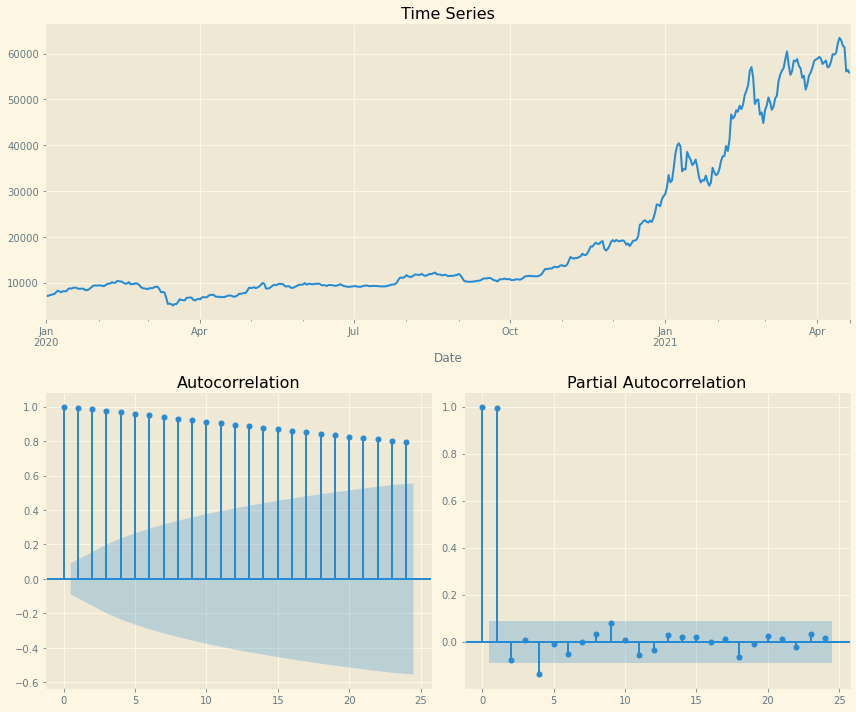

In [23]:
plotds(df.Close)

In [24]:
result = adfuller(df.Close)
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: 1.3950905642959415
p-value: 0.9970917246171098
Critical Values:
	1%: -3.4446148284445153
	5%: -2.8678299626609314
	10%: -2.5701203107928157


The dataset clearly shows a non-stationary signal with an increasing trend. The ACF is also showing an exponential decay while PACF has a strong correlation in lag 2.

In [25]:
# Calculate the mean value of first 55 rows and afterwards
mean1, mean2 =df['Close'].iloc[:55].mean(), df['Close'].iloc[55:].mean()

# Calculate the variance value of first 125 rows and afterwards
var1, var2 = df['Close'].iloc[:55].var(), df['Close'].iloc[55:].var()

# Display mean and variance of two parts of the time series
print('mean1 = %f, mean2 = %f' % (mean1, mean2))
print('variance1 = %f, variance2 = %f' % (var1, var2))

mean1 = 8970.564599, mean2 = 20903.750221
variance1 = 810901.297799, variance2 = 295390846.868361


### Lets run the differencing on out dataset:

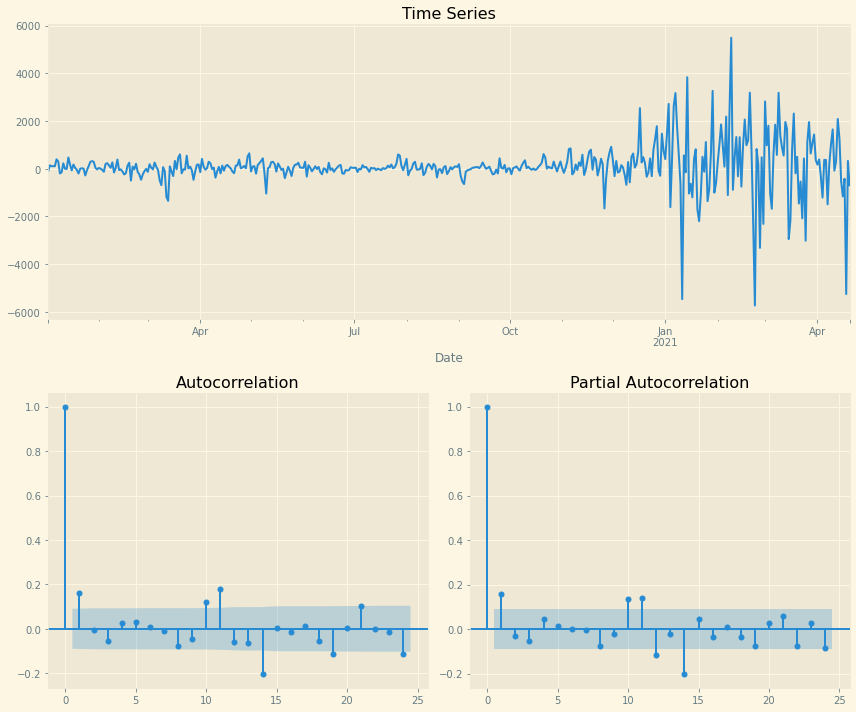

In [26]:
diff = df['Close'].diff().dropna()

plotds(diff)

In [27]:
result = adfuller(diff)
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -6.430382433551767
p-value: 1.7032072784101367e-08
Critical Values:
	1%: -3.4446148284445153
	5%: -2.8678299626609314
	10%: -2.5701203107928157


#### The p-value is below the threshold of 0.05. Thus, we can conclude that the time series is now stationary.

In [28]:
# Calculate the mean value of first 55 rows and afterwards
mean1, mean2 =diff.iloc[:55].mean(), diff.iloc[55:].mean()

# Calculate the variance value of first 125 rows and afterwards
var1, var2 = diff.iloc[:55].var(), diff.iloc[55:].var()

# Display mean and variance of two parts of the time series
print('mean1 = %f, mean2 = %f' % (mean1, mean2))
print('variance1 = %f, variance2 = %f' % (var1, var2))

mean1 = 41.838211, mean2 = 109.950692
variance1 = 36731.083786, variance2 = 953334.680054


#### Let's see if the second differencing will bring better results:

In [29]:
diff1 = df.Close.diff().diff().dropna()

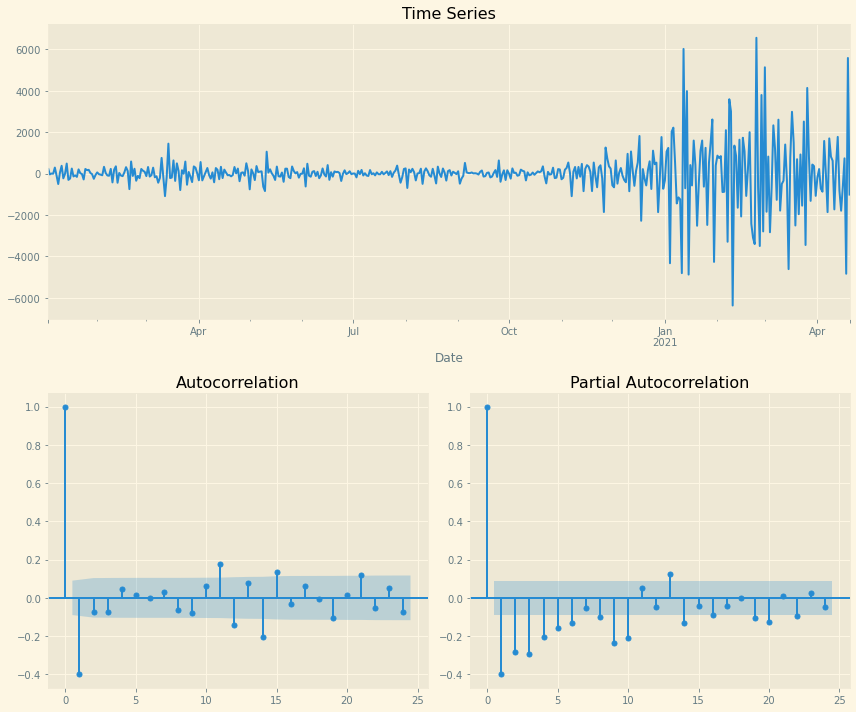

In [30]:
plotds(diff1)

#### As there is no much difference between first and second differencing we can choose the order differencing as 1, the d = 1.

We can perform the above (finding the number for diffrencing) using following library:

In [31]:
#!pip install pmdarima

In [32]:
from pmdarima.arima.utils import ndiffs

In [33]:
ndiffs(df['Close'], test='adf')

1

#### We can see that this method suggest the d = 1 as well.

p - is the order of the Auto Regressive (AR) term. It refers to the number of lags to be used as predictors. <br>
We can find out the required number of AR terms by inspecting the Partial Autocorrelation (PACF) plot.<br>
The partial autocorrelation represents the correlation between the series and its lags.<br>

We can observe that the PACF lag number 1 is significant as it's above the significance line.

q is the order of the Moving Average(MA) term. <br>
It refers to the number of lagged forecast errors that should go into the ARIMA model. <br>
We can look at the ACF plot for the number of MA terms.

We are choosing lag 1 for our model.

### Fitting the ARIMA model with the order of p,d,q as has been decided above:

In [34]:
model = ARIMA(df['Close'], order=(1,1,1))
result = model.fit(disp=0)

In [35]:
print(result.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  475
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3909.091
Method:                       css-mle   S.D. of innovations            907.505
Date:                Tue, 10 May 2022   AIC                           7826.182
Time:                        15:17:19   BIC                           7842.835
Sample:                    01-02-2020   HQIC                          7832.731
                         - 04-20-2021                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           101.5933     48.746      2.084      0.037       6.053     197.134
ar.L1.D.Close     0.0458      0.213      0.214      0.830      -0.373       0.464
ma.L1.D.Close     0.1175      0.210     

The “residuals” in a time series model are what is left over after fitting a model. For many (but not all) time series models, the residuals are equal to the difference between the observations and the corresponding fitted values:

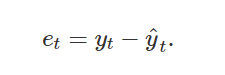

Residuals are useful in checking whether a model has adequately captured the information in the data. A good forecasting method will yield residuals with the following properties:<br>

1. The residuals are uncorrelated. If there are correlations between residuals, then there is information left in the residuals which should be used in computing forecasts.<br>
2. The residuals have zero mean. If the residuals have a mean other than zero, then the forecasts are biased.<br>

https://otexts.com/fpp2/residuals.html

Text(0.5, 1.0, 'Histogram of residuals')

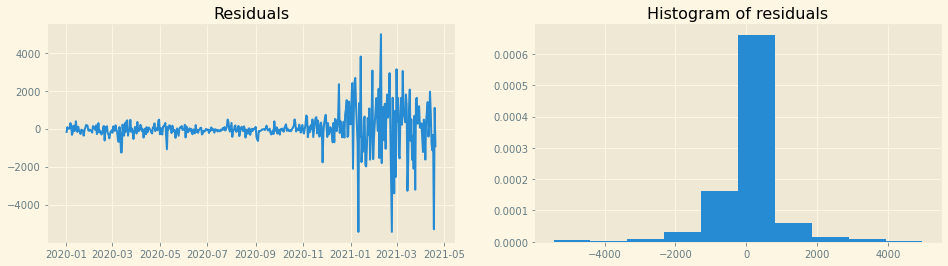

In [36]:
residuals = pd.DataFrame(result.resid)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))

ax1.plot(residuals)
ax1.set_title('Residuals')
ax2.hist(residuals, density=True)
ax2.set_title('Histogram of residuals')

The mean of the residuals is close to zero with few exceptions and there is no significant correlation in the residuals series.<br> The time plot of the residuals shows that the variation of the residuals stays much the same across the historical data, apart from the few outlier, and therefore the residual variance can be treated as constant.<br>
This can also be seen on the histogram of the residuals. <br>
The histogram suggests that the residuals may not be normal — the tails seems a little too long, having few outliers on both sites.<br>
Consequently, forecasts from this method will probably be quite good, but prediction intervals that are computed assuming a normal distribution may be inaccurate.

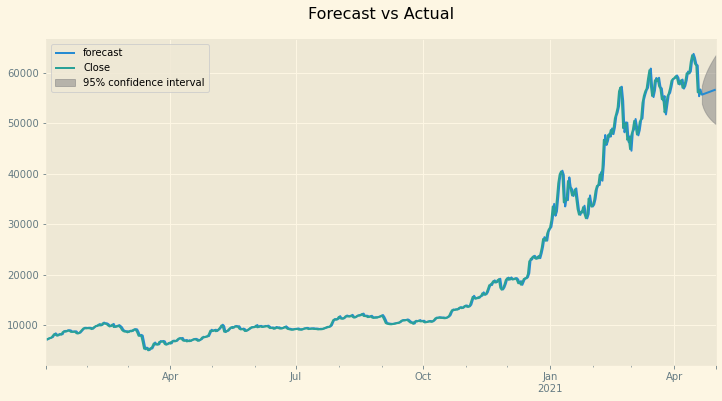

In [37]:
# Our dataset has 476 observations, adding 10 to forecast 10 months 

result.plot_predict(start=1, end=486, dynamic=False);
plt.title("Forecast vs Actual", pad=20)
plt.legend(loc="upper left")
plt.show()

The orange line is the data that we know. The blue line represents our forecast plus 10 months into the future. The gray area around our forecast is the 95% confidence interval.

As we can see on the graph above the Close the the forcasted line are very close to each other, we can conclude that our model works well.

### Testing our model:

#### Generating Train test split data:

In [38]:
# 80% will be training data, 20% testing

n = int(len(df.Close) * 0.80)
train = df.Close[:n]       
test = df.Close[n:]

In [39]:
print(len(train))
print(len(test))

380
96


In [40]:
model = ARIMA(train, order=(2,1,2))
result = model.fit(disp=0)

In [41]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                  379
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2904.499
Method:                       css-mle   S.D. of innovations            514.039
Date:                Tue, 10 May 2022   AIC                           5820.998
Time:                        15:17:20   BIC                           5844.623
Sample:                    01-02-2020   HQIC                          5830.374
                         - 01-14-2021                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            82.2868     29.988      2.744      0.006      23.511     141.063
ar.L1.D.Close     0.9582      0.048     19.796      0.000       0.863       1.053
ar.L2.D.Close    -0.9415      0.041    -23.103      0.000      -1.021      -0.862
ma.L1.D.Close    -0.7363      0.044    -16.631      0.000      -0.823      -0.650
ma.L2.D.Close     0.8525      0.056     15.308      0.000       0.743       0.962
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.5089           -0.8962j            1.0306           -0.1678
AR.2            0.5089           +0.8962j            1.0306            0.1678
MA.1            0.4319           -0.9932j            1.0831           -0.1847
MA.2            0.4319           +0.9932j            1.0831            0.1847
-----------------------------------------------------------------------------
"""

In [42]:
step = 10

fc, se, conf = result.forecast(step)

In [43]:
fc

array([40074.21682438, 39900.9949278 , 38359.23084078, 37125.88068921,
       37476.53836105, 39054.65276749, 40317.60073036, 40122.9021286 ,
       38828.18613321, 37851.78264344])

In [44]:
conf

array([[39066.71848067, 41081.71516809],
       [38310.2153038 , 41491.77455181],
       [36269.1897599 , 40449.27192165],
       [34683.1048153 , 39568.65656312],
       [34813.74307021, 40139.33365189],
       [36227.59042796, 41881.71510702],
       [37306.4738459 , 43328.72761482],
       [36872.59013855, 43373.21411865],
       [35319.60905465, 42336.76321178],
       [34131.07835032, 41572.48693656]])

In [45]:
fc = pd.Series(fc, index=test[:step].index)
lower = pd.Series(conf[:,0], index=test[:step].index)
upper = pd.Series(conf[:,1], index=test[:step].index)

### Plotting testing results:

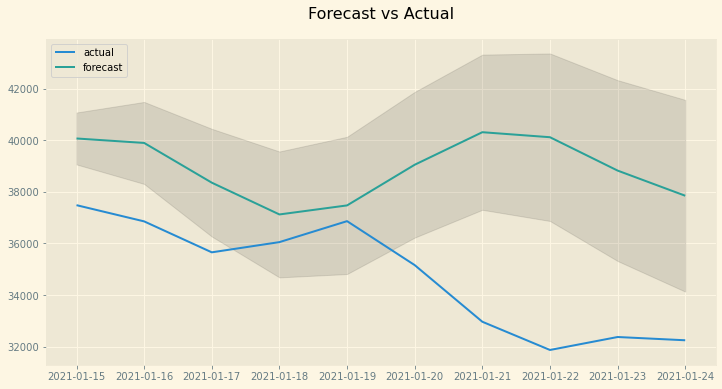

In [46]:
plt.figure(figsize=(12,6))
plt.plot(test[:step], label="actual")
plt.plot(fc, label="forecast")
plt.fill_between(lower.index, lower, upper, color="k", alpha=0.1)
plt.title("Forecast vs Actual", pad=20)
plt.legend(loc="upper left")
plt.show()

In [47]:
start = len(train)
end   = len(train) + len(test) - 1
predictions_1 = result.predict(start = start, end = end, dynamic = False, typ = 'levels').rename('ARIMA Predictions')
print(predictions_1)

2021-01-15    40074.216824
2021-01-16    39900.994928
2021-01-17    38359.230841
2021-01-18    37125.880689
2021-01-19    37476.538361
                  ...     
2021-04-16    45932.149434
2021-04-17    45902.940589
2021-04-18    45958.066810
2021-04-19    46119.300717
2021-04-20    46302.807837
Freq: D, Name: ARIMA Predictions, Length: 96, dtype: float64


### Model evaluation using R2_score:

In [48]:
# Create a dataframe to store r2 score
evaluation_results_1 = pd.DataFrame({'r2_score': r2_score(test, predictions_1)}, index = [0])

# Add columns in the dataframe 'evaluation_results'
evaluation_results_1['mean_absolute_error'] = mean_absolute_error(test, predictions_1)
evaluation_results_1['mean_squared_error'] = mean_squared_error(test, predictions_1)
evaluation_results_1['root_mean_squared_error'] = np.sqrt(mean_squared_error(test, predictions_1))
evaluation_results_1['mean_absolute_percentage_error'] = np.mean(np.abs(predictions_1 - test)
                                                               /np.abs(test))*100 
# Display the results
evaluation_results_1

,r2_score,mean_absolute_error,mean_squared_error,root_mean_squared_error,mean_absolute_percentage_error
0,-0.184518,9368.206777,1.083362e+08,10408.467695,18.179392


### The model showed negative  accuracy as R2 score is -0.18, this is very low.<br>

### The problem with plain ARIMA model is it does not support seasonality and that is most likely part of our problem and why the results are so bad.

In this dataset we could see seasonality pattern, therefore, we proceed with SARIMA model which uses seasonal differencing. <br>
Seasonal differencing is just similar to regular differencing, but, instead of subtracting successive terms, we subtract the value from previous season.

### SARIMA:

Our next step is parameter Selection for SARIMA Model.<br> 
Our goal here is to use a “grid search” to find the optimal set of parameters that yields the best performance for our model.

In [49]:
from statsmodels.tsa.arima_model import ARIMA
# A nested loop is written to calculate the AIC values
aicVal=[]
for d in range(1,3):
    for ari in range(0, 3):
        for maj in range(0,3):
            try:
                arima_obj = ARIMA(df['Close'].tolist(), order=(ari,d,maj))
                arima_obj_fit=arima_obj.fit()
                aicVal.append([ari, d, maj, arima_obj_fit.aic])
            except ValueError:
                pass
print(aicVal)

[[0, 1, 0, 7834.693076133444], [0, 1, 1, 7824.227784466466], [0, 1, 2, 7826.146778927063], [1, 1, 0, 7824.480397450816], [1, 1, 1, 7826.182166299046], [2, 1, 0, 7825.976093577558], [2, 1, 1, 7827.6800776007385], [2, 1, 2, 7826.637396848999], [0, 2, 0, 8064.960720007183], [0, 2, 1, 7823.103049088782], [0, 2, 2, 7813.418008679271], [1, 2, 0, 7984.084453625748], [1, 2, 1, 7813.76969541264], [1, 2, 2, 7815.401529854253], [2, 2, 0, 7946.121318875763], [2, 2, 1, 7815.103139374518], [2, 2, 2, 7816.5796036111315]]


The above output suggests that SARIMAX(1, 1, 1)x(0, 2, 2, 30) yields the lowest AIC value of 7813.41. Therefore we should consider this to be optimal option.

### Fitting the SARIMA model

In [50]:
mod = sm.tsa.statespace.SARIMAX(df['Close'],
                                order=(1, 1, 1),
                                seasonal_order=(0, 2, 2, 30),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_Sarima = mod.fit()
print(results_Sarima.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0797      0.251      0.317      0.751      -0.413       0.573
ma.L1          0.1012      0.246      0.412      0.680      -0.380       0.582
ma.S.L30      -1.9192      0.032    -59.739      0.000      -1.982      -1.856
ma.S.L60       1.0297      0.034     29.893      0.000       0.962       1.097
sigma2      1.026e+06   7.08e-08   1.45e+13      0.000    1.03e+06    1.03e+06


We should always run model diagnostics to investigate any unusual behavior.

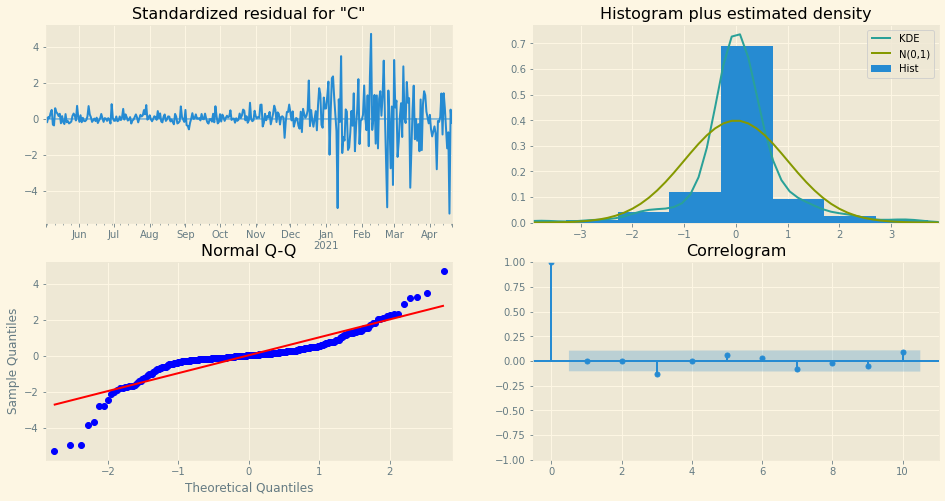

In [51]:
results_Sarima.plot_diagnostics(figsize=(16, 8))
plt.show()

It is not perfect, we know we have few outliers in our data, however, our model diagnostics suggests that the model residuals are near normally distributed.

#### Validating forecasts

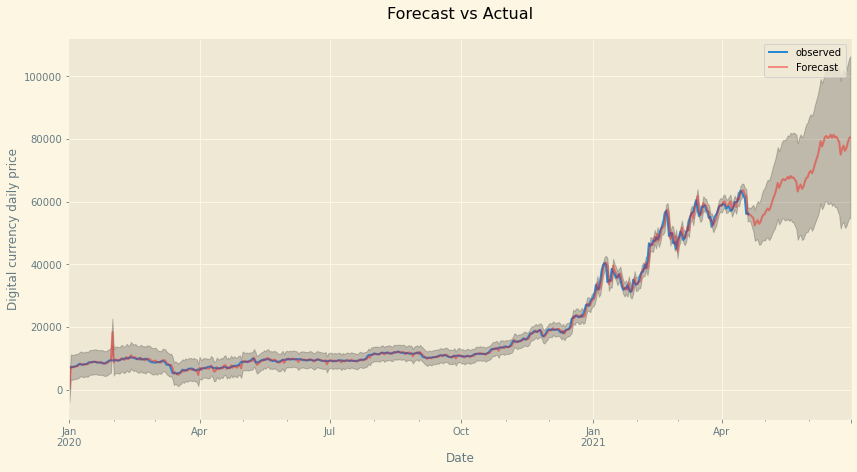

In [67]:
#our data ends on the day: 2021-04-20, we are trying to visualise prediction for 2 months, therefore our end time will be; 2021-06-20.

pred = results_Sarima.get_prediction(start=pd.to_datetime('2020-01-01'),end=pd.to_datetime('2021-06-30'), dynamic=False)
pred_ci = pred.conf_int()
ax = df.Close['2010':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.4, figsize=(14, 7), color='red')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Digital currency daily price')
plt.title("Forecast vs Actual", pad=20)
plt.legend()
plt.show()


The line plot is showing the observed values compared to the rolling forecast predictions. Overall, our forecasts align with the true values very well, showing an upward trend starts from the beginning of the year and captured the seasonality toward the end of the year.

To evaluate the model performance, we calculate the R-squared score and the root mean square error of my dataset to test the authenticity of the model. 

R Squared gives an indication of how well a model fits a given dataset. It indicates how close the regression line (i.e the predicted values plotted) is to the actual data values. The R squared value lies between 0 and 1 where 0 indicates that this model doesn't fit the given data and 1 indicates that the model fits perfectly to the dataset provided. 

Root Mean Squared Error (RMSE) is the distance, on average, of a data point from the fitted line, measured along a vertical line.

In [53]:
# Divide into train and validation set to calculate R-squared score and mean absolute percentage error 
train = df.Close[:int(0.80 * (len(df.Close)))]
test  = df.Close[int(0.80 * (len(df.Close))):]

train.shape, test.shape

((380,), (96,))

In [54]:
train.head()

Date
2020-01-01    7195.641243
2020-01-02    7072.362910
2020-01-03    7215.680840
2020-01-04    7320.664035
2020-01-05    7429.535437
Name: Close, dtype: float64

In [55]:
start = len(train)
end   = len(train) + len(test) - 1
predictions_2 = results_Sarima.predict(start = start, end = end, dynamic = False, typ = 'levels').rename('SARIMA Predictions')
print(predictions_2)

2021-01-15    39602.860771
2021-01-16    37983.458043
2021-01-17    37007.217363
2021-01-18    35482.638501
2021-01-19    36434.503631
                  ...     
2021-04-16    63585.021578
2021-04-17    62179.804319
2021-04-18    61905.537636
2021-04-19    55858.823890
2021-04-20    56003.072397
Freq: D, Name: SARIMA Predictions, Length: 96, dtype: float64


### Evaluating results:

In [56]:
# Create a dataframe to store r2 score
evaluation_results_2 = pd.DataFrame({'r2_score': r2_score(test, predictions_2)}, index = [0])

# Add columns in the dataframe 'evaluation_results'
evaluation_results_2['mean_absolute_error'] = mean_absolute_error(test, predictions_2)
evaluation_results_2['mean_squared_error'] = mean_squared_error(test, predictions_2)
evaluation_results_2['root_mean_squared_error'] = np.sqrt(mean_squared_error(test, predictions_2))
evaluation_results_2['mean_absolute_percentage_error'] = np.mean(np.abs(predictions_2 - test)
                                                               /np.abs(test))*100 
# Display the results
evaluation_results_2

,r2_score,mean_absolute_error,mean_squared_error,root_mean_squared_error,mean_absolute_percentage_error
0,0.964021,1357.133309,3.290602e+06,1814.0017,2.844602


## Conclusion

The model showed 96.0% accuracy as R2 score is 0.96, this is very high.<br>
